Analysis Titan's winning 921 blocks.

Author: Bryanzk
Date Modified: 2024.04.11
License: CC0

# Thing To Consider About Builder Labels
## Facts
* A builder can have many pubkeys.
* A builder's old pubkey can be dropped, but the block built using this now obsoleted pubkey still exist. 
* A builder can quit being a builder, but the blocks built by it still exists.
* A builder can change its label for its pubkeys. 
* A builder can impose as other builders via using similar labels. 
* An imposeter builder can be applied with all the facts above. 
* The most time-accurate builder info need to be combined with the block number to avoid the changing label. 


## Current Builder Info Source
1. https://github.com/dataalways/mevboost-data/tree/main/data The block data contains the builder pubkey and builder label. 
2. https://docs.google.com/spreadsheets/d/1rPR4ZcPAOfLzBN4Lk_Ja2X8h6KkdINJBZy6245Dljoo/edit#gid=0  TLDR's paper's data source


## Question Worth Noting
Could a pubkey belong to different entities, not labels, through out the time? 

## You Need to Decide
1. Do you want to show the historical data with builder labels at the time when the block is built? 
1. Do you want to show the newest builder labels with the historcial data?

**Usually, the analysis should provide the block number list to get the right builder info.**

## For this case
We are using data from Dataalways' MEVboost-data github project, which has embeded builder label with each block. We can safely assume that the builder label is matching each block at the time it's produced. 

### Details
#### For the 921 blocks won by Titan
1. Use the embeded builder label with each block. 
2. If any of the builder label is NaN, then use the pubkey to query the latest builder info dataset. 
3. If it's still NaN, then use the pubkey to query the TLDR builder dataset. 
4. If it's still NaN, then take the first 10 chars of the pubkey as builder label. 
5. However, the analysis has to check if any duplicate meaning builder exists. 

#### For the bidding data from Eden
It only contains builder pubkeys. So we have to join the pubkey and the block number to find the right builder label. (NEED TO BE TESTED)

In [5]:
### Get the bidding data for the 921 blocks that Titan won. This is the most time consuming part of the data preparation process.
from data_prep_utils import *
from plot_prep_utils import *
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import os
import pandas as pd # type: ignore
import requests
from bs4 import BeautifulSoup



df_block =  pd.read_csv("blocks_by_titan_19433573_to_19440930_with_builders.csv")

# Read 921 blocks' bidding data. Titan won these 921 blocks.
pd.options.display.float_format = '{:.0f}'.format
# Read the titan 921 block bidding history parquet file
df_bidding = pd.read_parquet('titan921.parquet', engine='pyarrow')
# print(df_bidding.columns)

min_titan_block = df_bidding["block_number"].min()
max_titan_block = df_bidding["block_number"].max()
print(f"min_titan_block: {min_titan_block}, max_titan_block: {max_titan_block}")

print( df_bidding["block_number"].nunique())

df_blocks_with_builder = get_raw_block_data_with_winning_bids_and_latest_builder_label()
print('bidding - columns - before merge:')
print(df_bidding.columns)
print('bidding - rows - before merge:' )
print( df_bidding.shape[0])



df_blocks_with_builder = get_raw_block_data_with_winning_bids_and_latest_builder_label()
df_builder_and_block_only = df_blocks_with_builder[['block_number', 'builder_pubkey', 'builder_label']]
df_builder_and_block_only.set_index(['block_number', 'builder_pubkey'], inplace=True)

inner_merged_df = pd.merge(df_bidding, df_builder_and_block_only, on='block_number', how='inner')

# print(inner_merged_df.columns)


print('bidding - columns - after merge on block number:')

print(inner_merged_df.columns)
print('bidding - rows - after merge on block number:')
print( inner_merged_df.shape[0])
print('bidding - empty builder label rows - after merge on block number:' )
print(inner_merged_df['builder_label'].isna().sum())


# # Step 2: Left join on builder_pubkey from the result of the inner join
# result_df = pd.merge(inner_merged_df, df_blocks_with_builder[['builder_pubkey', 'builder_label']], on='builder_pubkey', how='left')

# print(result_df.columns)

# # Add org_builder_label column
# result_df['org_builder_label'] = result_df['builder_label']

# # Drop unnecessary columns if any
# result_df = result_df.drop(['builder_label'], axis=1)
    
    



# df_bidding = get_titan_won_921_blocks_bidding_data()
# print(df_bidding.columns)
# print(df_bidding['builder_pubkey'].head(2))
# print(df_bidding['builder_pubkey'].isna().sum())
# org_none_count = df_bidding['org_builder_label'].isna().sum()



min_titan_block: 19433573, max_titan_block: 19440930
921
6756
0
bidding - columns - before merge:
Index(['block_timestamp', 'relay', 'slot', 'parent_hash', 'block_hash',
       'builder_pubkey', 'proposer_pubkey', 'proposer_fee_recipient',
       'gas_limit', 'gas_used', 'value', 'num_tx', 'block_number', 'timestamp',
       'timestamp_s', 'timestamp_ms', 'optimistic_submission'],
      dtype='object')
bidding - rows - before merge:
1698090
6756
0
bidding - columns - after merge on block number:
Index(['block_timestamp', 'relay', 'slot', 'parent_hash', 'block_hash',
       'builder_pubkey', 'proposer_pubkey', 'proposer_fee_recipient',
       'gas_limit', 'gas_used', 'value', 'num_tx', 'block_number', 'timestamp',
       'timestamp_s', 'timestamp_ms', 'optimistic_submission',
       'builder_label'],
      dtype='object')
bidding - rows - after merge on block number:
0
bidding - empty builder label rows - after merge on block number:
0


In [4]:


df_blocks = get_raw_block_data_with_winning_bids_and_latest_builder_label()


## Switch the builder info from the data always's mev-boost data project 
## to the CSV exported from TLDR's paper's data source
## https://docs.google.com/spreadsheets/d/1rPR4ZcPAOfLzBN4Lk_Ja2X8h6KkdINJBZy6245Dljoo/edit#gid=0
# df_builder_info = get_builder_info_from_dataalways_block(df)
# df_builder_info = df_blocks[['block_number', 'builder_pubkey', 'builder_label']].copy()

KeyError: 'org_builder_label'

In [2]:

# get the block numbers of the titan won blocks and all the blocks in this scope
min_titan_block = df_bidding["block_number"].min()
max_titan_block = df_bidding["block_number"].max()
print(f"min_titan_block: {min_titan_block}, max_titan_block: {max_titan_block}")

test_df_join_block = pd.merge(df_blocks, df_bidding, on="block_number", how="inner")
print(f"test_df_join_block: {test_df_join_block.shape[0]}")


df_old_builder =  get_builder_info_from_dataalways_block(None)
test_df_join_block_and_builder = pd.merge(df_bidding, df_old_builder, on= "builder_pubkey", how="left")
print(f"test_df_join_block_and_builder: {test_df_join_block_and_builder.shape[0]}")
print(test_df_join_block_and_builder.columns)


test_df_join_block_old_builder = pd.merge(df_blocks, df_old_builder, on="builder_pubkey", how="left")
print(f"test_df_join_block_old_builder: {test_df_join_block_old_builder.shape[0]}")

og_builder = get_builder_info_from_dataalways_block(None)
tldr_builder = get_builder_info_from_latest_TLDR_talk()

all_builder = pd.merge(og_builder, tldr_builder, on="builder_pubkey", how="outer")

df_imposter = all_builder[all_builder["builder_label_y"] == 'imposter']


min_titan_block: 19433573, max_titan_block: 19440930
test_df_join_block: 1698090


/Users/kezheng/temp/mevboost-data/examples/data_prep_utils.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2023-10-10 12:17:46.267000', '2023-10-10 12:17:59.157000',
 '2023-10-10 12:18:11.103000', '2023-10-10 12:18:23.431000',
 '2023-10-10 12:18:35.193000', '2023-10-10 12:18:47.158000',
 '2023-10-10 12:18:59.140000', '2023-10-10 12:19:11.045000',
 '2023-10-10 12:19:23.192000', '2023-10-10 12:19:47.657000',
 ...
 '2024-04-09 18:52:47.037000', '2024-04-09 18:52:59.769000',
 '2024-04-09 18:53:11.636000', '2024-04-09 18:53:23.926000',
 '2024-04-09 18:53:35.903000', '2024-04-09 18:53:59.772000',
 '2024-04-09 18:54:11.705000', '2024-04-09 18:54:23.194000',
 '2024-04-09 18:54:35.642000', '2024-04-09 18:54:47.768000']
Length: 1140830, dtype: datetime64[ns]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:,'bid_timestamp_ms'] = pd.to_datetime(df['bid

test_df_join_block_and_builder: 1698090
Index(['block_timestamp', 'relay', 'slot', 'parent_hash', 'block_hash',
       'builder_pubkey', 'proposer_pubkey', 'proposer_fee_recipient',
       'gas_limit', 'gas_used', 'value', 'num_tx', 'block_number', 'timestamp',
       'timestamp_s', 'timestamp_ms', 'optimistic_submission', 'ts_diff',
       'ts_diff_secs', 'builder_label'],
      dtype='object')
test_df_join_block_old_builder: 1140830


/Users/kezheng/temp/mevboost-data/examples/data_prep_utils.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2023-10-10 12:17:46.267000', '2023-10-10 12:17:59.157000',
 '2023-10-10 12:18:11.103000', '2023-10-10 12:18:23.431000',
 '2023-10-10 12:18:35.193000', '2023-10-10 12:18:47.158000',
 '2023-10-10 12:18:59.140000', '2023-10-10 12:19:11.045000',
 '2023-10-10 12:19:23.192000', '2023-10-10 12:19:47.657000',
 ...
 '2024-04-09 18:52:47.037000', '2024-04-09 18:52:59.769000',
 '2024-04-09 18:53:11.636000', '2024-04-09 18:53:23.926000',
 '2024-04-09 18:53:35.903000', '2024-04-09 18:53:59.772000',
 '2024-04-09 18:54:11.705000', '2024-04-09 18:54:23.194000',
 '2024-04-09 18:54:35.642000', '2024-04-09 18:54:47.768000']
Length: 1140830, dtype: datetime64[ns]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:,'bid_timestamp_ms'] = pd.to_datetime(df['bid

In [3]:
print(df_bidding.columns)

Index(['block_timestamp', 'relay', 'slot', 'parent_hash', 'block_hash',
       'builder_pubkey', 'proposer_pubkey', 'proposer_fee_recipient',
       'gas_limit', 'gas_used', 'value', 'num_tx', 'block_number', 'timestamp',
       'timestamp_s', 'timestamp_ms', 'optimistic_submission', 'ts_diff',
       'ts_diff_secs'],
      dtype='object')


In [ ]:
print(df_blocks[df_blocks["org_builder_label"]==""].shape[0])
print(df_blocks[df_blocks["builder_label"]==""].shape[0])
print(df_blocks[df_blocks["builder_label"].isna()].shape[0])
print("Latest:")
print(df_blocks["builder_label"].unique())
print("Org:")
print(df_blocks["org_builder_label"].unique())
print("TLDR:")
print(df_blocks["tldr_builder_label"].unique())



# get the block numbers of the titan won blocks and all the blocks in this scope
min_titan_block = df_bidding["block_number"].min()
max_titan_block = df_bidding["block_number"].max()


# df_all_blocks = get_raw_block_data_with_winning_bids_and_latest_builder_label()
# print(df.head(1))
# print(dft.head(1))


In [36]:
df_filtered = df_all_blocks[(df_all_blocks["block_number"] >= min_titan_block) & (df_all_blocks["block_number"] <= max_titan_block)]   
df_filtered.rename(columns={'builder_label': 'org_builder_label'}, inplace=True)


df_filtered_with_new_builder_label = pd.merge(df_filtered, df_builder_info, how='left', on='builder_pubkey')
df_filtered_with_new_builder_label.rename(columns={'builder_label': 'tldr_builder_label'}, inplace=True)
df_filtered_with_new_builder_label['builder_label'] = df_filtered_with_new_builder_label['tldr_builder_label'].fillna(df_filtered_with_new_builder_label['org_builder_label'])
nan_rows = df_filtered_with_new_builder_label[df_filtered_with_new_builder_label['tldr_builder_label'].isna()]
empty_rows = df_filtered_with_new_builder_label[df_filtered_with_new_builder_label['org_builder_label'] == '']
# print(nan_rows)
# print(empty_rows)
df_filtered_with_new_builder_label.loc[df_filtered_with_new_builder_label['builder_label'] == '', 'builder_label'] = df_filtered_with_new_builder_label['builder_pubkey'].str[:10]
# print(df_joined[df_joined['org_builder_label'] == ''])

print(df_filtered_with_new_builder_label['builder_label'].unique())


print("Number of blocks in the scope: ", df_filtered["block_number"].nunique())
print("Starting time of the scope: ", df_filtered["block_datetime"].min())
print("Ending time of the scope: ", df_filtered["block_datetime"].max())
print("Number of blocks won by Titan: ", df_bidding["block_number"].nunique())


mask1 = df_bidding["block_number"] == 19433573
mask2 = df_bidding["num_tx"] == 171

filtered_dft = df_bidding[mask1 & mask2]

['Titan' 'beaverbuild' 'flashbots' 'jetbldr' 'lokibuilder' 'builder0x69'
 'rsync' 'tbuilder' '8c394db9' 'penguin' 'Gambit Labs' 'EigenPhi'
 'BuildAI' 'bloXroute' 'BTCS' 'ð\x9f¦\x84' 'Titan Builder' 'boba-builder'
 'Manifold: coinbase' 'bobTheBuilder' 'geth' '0x83bee517'
 'I can haz block?' 'antbuilder' 'Bitget(https://www.bitget.com/)'
 '@penguinbuild.org' 'rpc.tbuilder.xyz' 'penguinbuild.org' 'jetbldr.xyz'
 '\x9areth/v0.1.0-alpha.22/linux' 'smithbot.xyz' 'smithbot']
Number of blocks in the scope:  6499
Starting time of the scope:  2024-03-14 13:34:23
Ending time of the scope:  2024-03-15 14:25:47
Number of blocks won by Titan:  921


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_36060/1582559413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename(columns={'builder_label': 'org_builder_label'}, inplace=True)


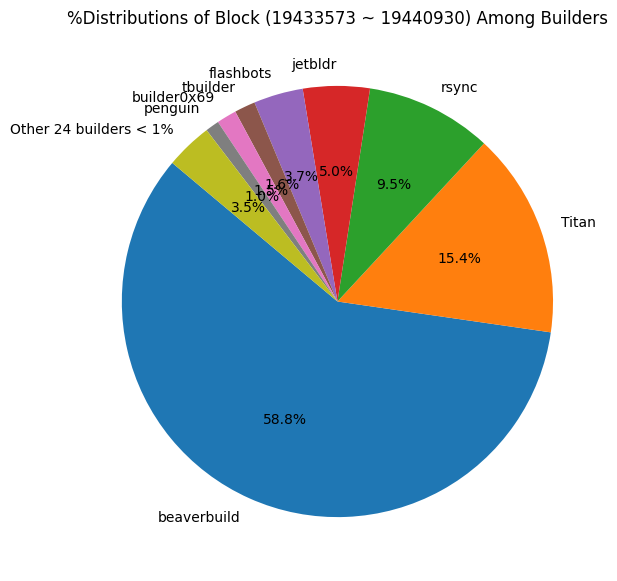

In [37]:
#plot a pie chart of the number of blocks built by each builder

# 计算各个builder_label的数量
builder_label_counts = df_filtered_with_new_builder_label['builder_label'].value_counts().reset_index()
builder_label_counts.columns = ['builder_label', 'block_count']
total_count = builder_label_counts["block_count"].sum()

# 提前处理，将小于1%的标签合并为"其他"
threshold = 0.01 * total_count
filtered_counts = builder_label_counts[builder_label_counts['block_count'] >= threshold]
other_builder_count = builder_label_counts[builder_label_counts['block_count'] < threshold]['builder_label'].count()
other_block_count = builder_label_counts[builder_label_counts['block_count'] < threshold]['block_count'].sum()

# filtered_counts = builder_label_counts["block_count" >= threshold]
# other_count = builder_label_counts["block_count" < threshold].sum()

# 添加"其他"类别
if other_builder_count > 0:
    other_row = pd.DataFrame([['Other ' + str(other_builder_count) + ' builders < 1%', other_block_count]], columns=['builder_label', 'block_count'])
    filtered_counts = pd.concat([filtered_counts, other_row], ignore_index=True)
    
    

# 绘制饼图
plt.figure(figsize=(10, 7))
plt.pie(filtered_counts['block_count'], labels=filtered_counts['builder_label'], autopct='%1.1f%%', startangle=140)

# plt.figure(figsize=(10, 7))
# plt.pie(filtered_counts, labels=filtered_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('%Distributions of Block (19433573 ~ 19440930) Among Builders')
plt.show()


In [25]:

# # Get the blocks where Titan won and the block datetime is in March 2024
# is_titan = df['builder_label'].str.contains('Titan', case=False, na=False)
# is_march = (df['block_datetime'].dt.month == 3) & (df['block_datetime'].dt.year == 2024)
# filtered_blocks = df[is_titan & is_march]['block_number']
# print(filtered_blocks.shape[0])
# filtered_blocks.to_csv('Titan_March_blocks.csv', index=False)


43379


In [6]:
# df_test = df[df["block_number"] == 19437870]
# dft_test = dft[dft["block_number"] == 19437870]


In [38]:
# Add builder label to dft
print(df_bidding.columns)
print(df_builder_info.columns)
print("before merge: ", df_bidding.shape[0])
df_bidding = pd.merge(df_bidding, df_builder_info[['builder_pubkey', 'builder_label']], on='builder_pubkey', how='left')
print("after merge: ", df_bidding.shape[0])

Index(['block_timestamp', 'relay', 'slot', 'parent_hash', 'block_hash',
       'builder_pubkey', 'proposer_pubkey', 'proposer_fee_recipient',
       'gas_limit', 'gas_used', 'value', 'num_tx', 'block_number', 'timestamp',
       'timestamp_s', 'timestamp_ms', 'optimistic_submission', 'ts_diff',
       'ts_diff_secs'],
      dtype='object')
Index(['builder_label', 'builder_pubkey'], dtype='object')
before merge:  1698090
after merge:  1698090


In [39]:
# Filter out the duplicate block_number records with the earliest bid_timestamp, which is the winning bid thru the fastest relay
# N.B.: this would omit the records with the same block_number but different bid_timestamp from differe relays
df_filtered = df_blocks.copy()
df_filtered = df_filtered.sort_values(['block_number', 'bid_timestamp_ms'])
df_filtered = df_filtered.drop_duplicates('block_number', keep='first')

# get the unique block numbers won by Titan
unique_block_numbers_won_by_titan = df_bidding['block_number'].unique()

df_filtered_titan = df_filtered[df_filtered['block_number'].isin(unique_block_numbers_won_by_titan)]
# df_filtered_titan.loc[:,'bid_timestamp_ms'] = pd.to_datetime(df_filtered['bid_timestamp_ms'], unit='ms')
print(df_filtered_titan.shape[0])

921


min:-3.0; max:3.0


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_36060/1104625551.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_titan.loc[:,'ts_diff_bins'] = pd.cut(
/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_36060/1104625551.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[(0.2, 0.3], (-0.2, -0.1], (0.0, 0.1], (-0.4, -0.3], (-0.7, -0.6], ..., (-0.8, -0.7], (-0.2, -0.1], (-0.7, -0.6], (-0.3, -0.2], (-0.4, -0.3]]
Length: 921
Categories (60, interval[float64, right]): [(-3.0, -2.9] < (-2.9, -2.8] < (-2.8, -2.7] < (-2.7, -2.6] ... (2.6, 2.7] < (2.7, 2.8] < (2.8, 2.9] < (2.9, 3.0]]' has dtype incompatible with category, please explicitly cast to 

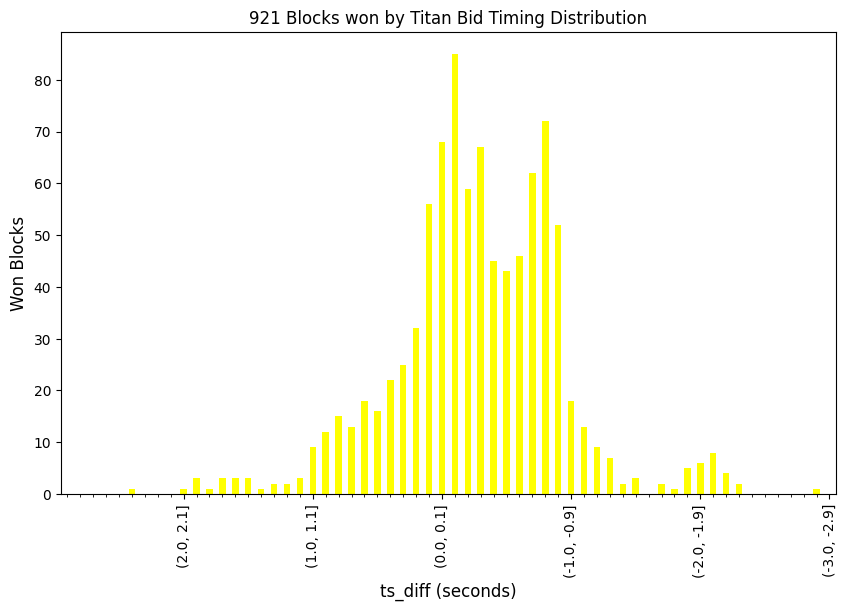

/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_36060/1104625551.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_avg = df_filtered_titan.groupby('ts_diff_bins')['num_tx'].mean().reset_index(name='avg_num_tx')
/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_36060/1104625551.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_med = df_filtered_titan.groupby('ts_diff_bins')['num_tx'].median().reset_index(name='med_num_tx')


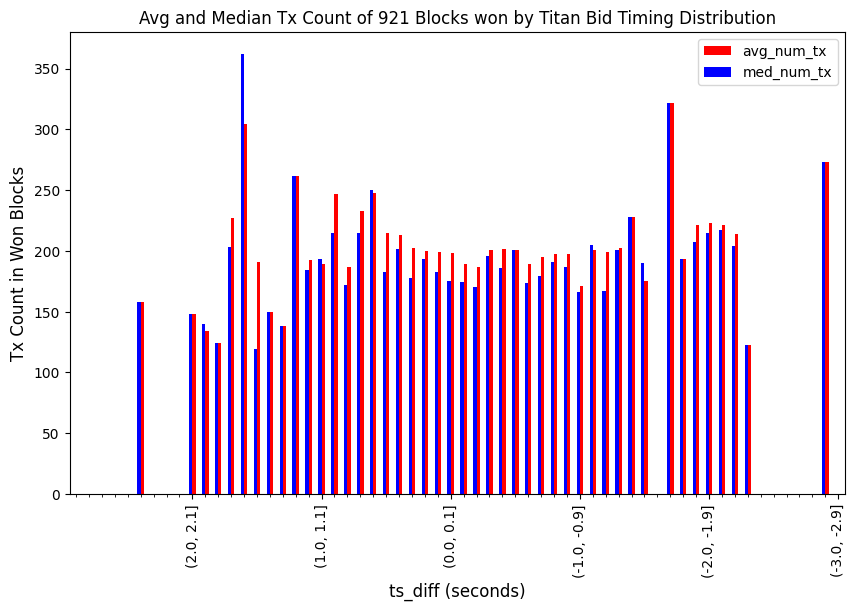

In [40]:
#Now the data is ready. Time to draw.
# Plot the stacked barchart of builder label with ts_diff as the x-axis
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker


# 计算 ts_diff 的最小和最大值
x_min = np.floor(df_filtered_titan['ts_diff_secs'].min())
x_max = np.ceil(df_filtered_titan['ts_diff_secs'].max())
print ("min:" + str(x_min) + "; max:" + str(x_max))


# 创建 `ts_diff_secs` 的区间（每0.1秒）
df_filtered_titan.loc[:,'ts_diff_bins'] = pd.cut(
    df_filtered_titan['ts_diff_secs'], 
    np.arange(x_min, x_max + 0.1, 0.1)  # 使用 x_min 和 x_max
)


df_filtered_titan.loc[:,'ts_diff_bins'] = df_filtered_titan['ts_diff_bins'].apply(lambda interval: pd.Interval(replace_small_values(interval.left), 
                                                                           replace_small_values(interval.right),
                                                                           interval.closed))


grouped = df_filtered_titan.groupby('ts_diff_bins')['block_number'].count()

ax = grouped.plot(kind='bar', figsize=(10,6), color='yellow')

adjust_plot_x_axis(ax)

plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Won Blocks', fontsize=12)
plt.title('921 Blocks won by Titan Bid Timing Distribution')

plt.show()

# save the grouped data to clipboard
grouped_transposed = grouped.transpose()
grouped_transposed.to_clipboard(index=True, header=True)

# draw the chart of average and median number of transactions in the blocks won by Titan
grouped_avg = df_filtered_titan.groupby('ts_diff_bins')['num_tx'].mean().reset_index(name='avg_num_tx')
grouped_med = df_filtered_titan.groupby('ts_diff_bins')['num_tx'].median().reset_index(name='med_num_tx')
merged_df = pd.merge(grouped_avg, grouped_med, on='ts_diff_bins')

txplot = merged_df.plot(x='ts_diff_bins', y=['avg_num_tx', 'med_num_tx'], kind='bar', color=['red', 'blue'], figsize=(10,6))
adjust_plot_x_axis(txplot)
plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Tx Count in Won Blocks', fontsize=12)
plt.title('Avg and Median Tx Count of 921 Blocks won by Titan Bid Timing Distribution')
# save the grouped data to clipboard
tx_grouped_transposed = merged_df.transpose()
merged_df.to_clipboard(index=True, header=True)



all max ts_diff_secs10.725
all min_ts_diff_secs-11.985
min:-12.0; max:11.0


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_36060/1895326894.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_bidding12s.loc[:,'ts_diff_bins'] = pd.cut(
/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_36060/1895326894.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[(1.3, 1.4], (0.7, 0.8], (0.1, 0.2], (-1.4, -1.3], (-0.5, -0.4], ..., (0.9, 1.0], (-1.5, -1.4], (0.7, 0.8], (1.5, 1.6], (0.9, 1.0]]
Length: 1695372
Categories (230, interval[float64, right]): [(-12.0, -11.9] < (-11.9, -11.8] < (-11.8, -11.7] < (-11.7, -11.6] ... (10.6, 10.7] < (10.7, 10.8] < (10.8, 10.9] < (10.9, 11.0]]' has dtype incompatible with category, please explicitly 

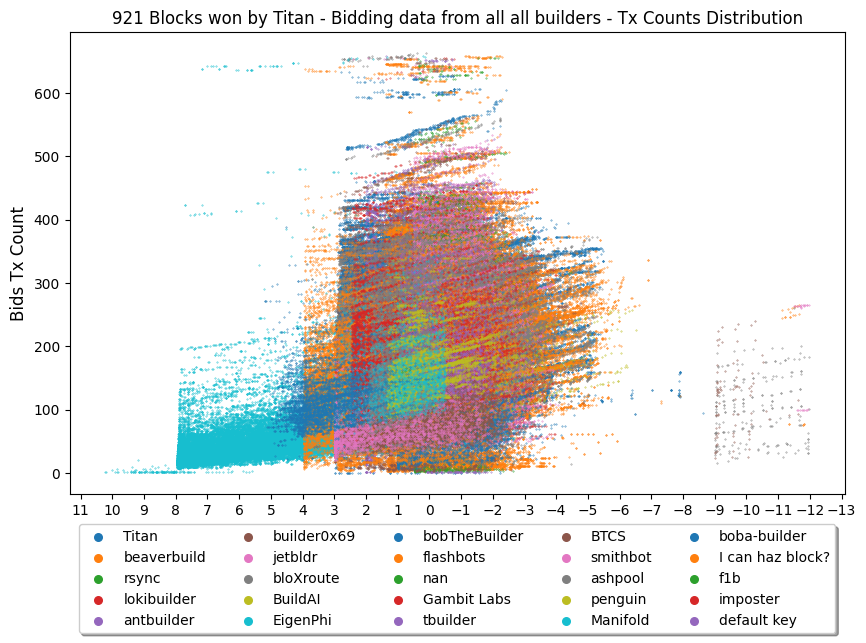

In [41]:
#Now the data is ready. Time to draw.
# Plot the stacked barchart of builder label with ts_diff as the x-axis
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

dft_bidding12s = df_bidding[df_bidding['ts_diff_secs'] > -12]

max_ts_diff_secs = dft_bidding12s['ts_diff_secs'].max()
print("all max ts_diff_secs" + str(max_ts_diff_secs))

min_ts_diff_secs = dft_bidding12s['ts_diff_secs'].min()
# print(dft_bidding12s[dft_bidding12s['ts_diff_secs'] == min_ts_diff_secs])
print("all min_ts_diff_secs" + str(min_ts_diff_secs))

# 计算 ts_diff 的最小和最大值
x_min = np.floor(dft_bidding12s['ts_diff_secs'].min())
x_max = np.ceil(dft_bidding12s['ts_diff_secs'].max())
print ("min:" + str(x_min) + "; max:" + str(x_max))


# 创建 `ts_diff_secs` 的区间（每0.1秒）
dft_bidding12s.loc[:,'ts_diff_bins'] = pd.cut(
    dft_bidding12s['ts_diff_secs'], 
    np.arange(x_min, x_max + 0.1, 0.1)  # 使用 x_min 和 x_max
)

dft_bidding12s.loc[:,'ts_diff_bins'] = dft_bidding12s['ts_diff_bins'].apply(lambda interval: pd.Interval(replace_small_values(interval.left), 
                                                                           replace_small_values(interval.right),
                                                                           interval.closed))

fig, ax = plt.subplots(figsize=(10,6))
adjust_plot_x_axis(ax)
for label in dft_bidding12s['builder_label'].unique():
    dft_label = dft_bidding12s[dft_bidding12s['builder_label'] == label]
    ax.scatter(dft_label['ts_diff_secs'], dft_label['num_tx'], s=0.1, label=label)
    
# 获取图例并修改点的大小
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
for handle in legend.legendHandles:
    handle._sizes = [30]

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bids Tx Count', fontsize=12)
plt.title('921 Blocks won by Titan - Bidding data from all all builders - Tx Counts Distribution')
plt.show()


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_36060/132297393.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


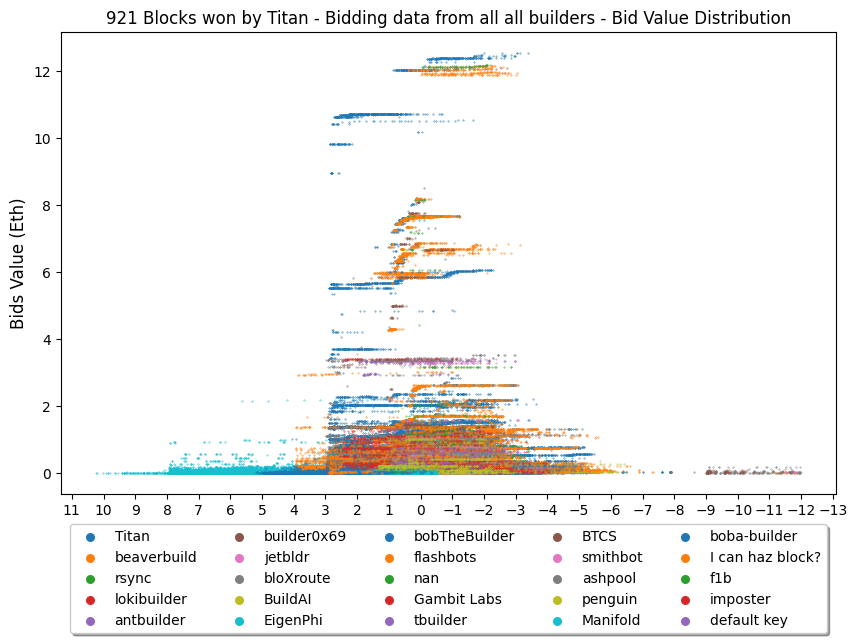

In [42]:
# draw the scatter plot of bid values
fig_bid, ax_bid = plt.subplots(figsize=(10,6))
adjust_plot_x_axis(ax_bid)
for label in dft_bidding12s['builder_label'].unique():
    dft_label = dft_bidding12s[dft_bidding12s['builder_label'] == label]
    ax_bid.scatter(dft_label['ts_diff_secs'], dft_label['value']/10**18, s=0.1, label=label)
    
# 获取图例并修改点的大小
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
for handle in legend.legendHandles:
    handle._sizes = [30]

ax_bid.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bids Value (Eth)', fontsize=12)
plt.title('921 Blocks won by Titan - Bidding data from all all builders - Bid Value Distribution')
plt.show()





max ts_diff_secs
2.975
min ts_diff_secs
-8.636
all builder 1695372
Titan 524295


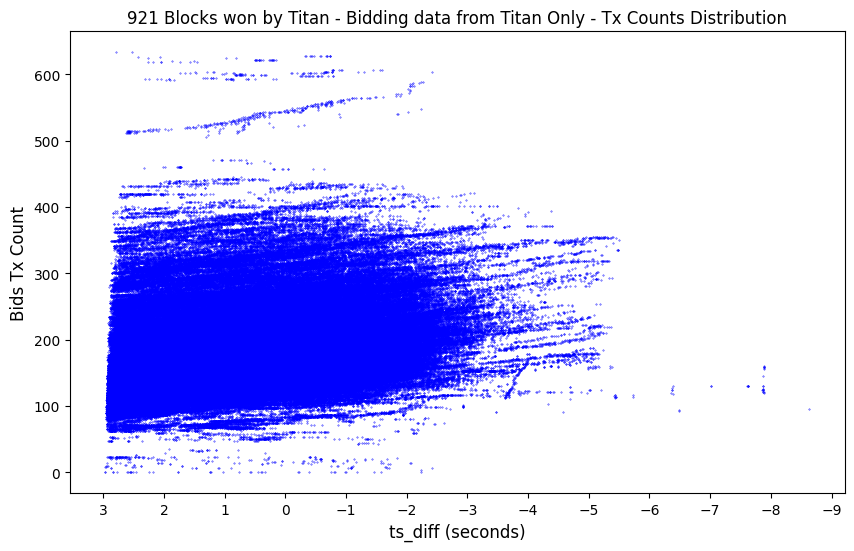

/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_36060/906654193.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_bidding12s_titan_only['bid_transformed'] = dft_bidding12s_titan_only['value'] / 10 ** 18


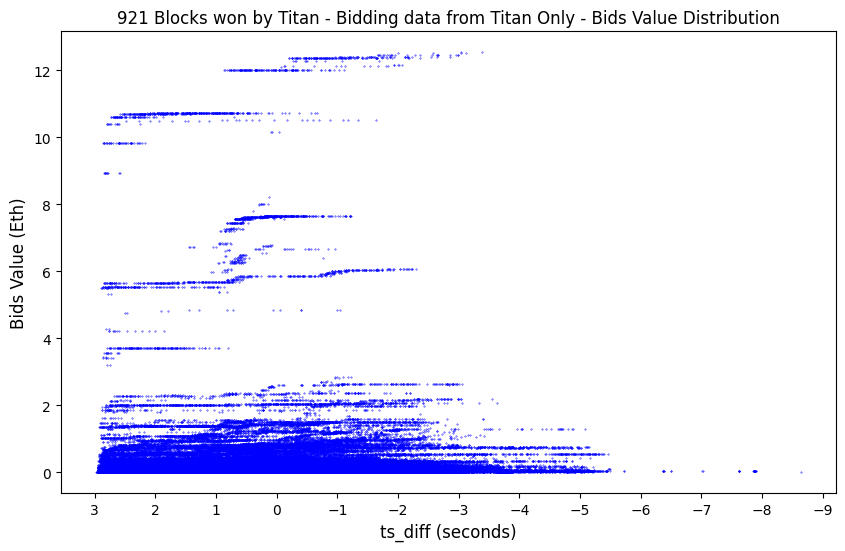

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [43]:


# draw the scatter plot of Titan only on Tx Count
titan_builders = df_builder_info[df_builder_info['builder_label'].str.contains('titan', case=False, na=False)]
dft_bidding12s_titan_only = dft_bidding12s[dft_bidding12s['builder_pubkey'].isin(titan_builders['builder_pubkey'])]




max_ts_diff_secs = dft_bidding12s_titan_only['ts_diff_secs'].max()
print("max ts_diff_secs")
print(max_ts_diff_secs)
# print(dft_bidding12s_titan_only[dft_bidding12s_titan_only['ts_diff_secs'] == max_ts_diff_secs])

min_ts_diff_secs = dft_bidding12s_titan_only['ts_diff_secs'].min()
print("min ts_diff_secs")
print(min_ts_diff_secs)
# print(dft_bidding12s_titan_only[dft_bidding12s_titan_only['ts_diff_secs'] == min_ts_diff_secs])


print("all builder " + str(dft_bidding12s.shape[0]))
print("Titan " + str(dft_bidding12s_titan_only.shape[0]))

bx = dft_bidding12s_titan_only.plot.scatter(x='ts_diff_secs', y='num_tx', figsize=(10,6), color='blue', s=0.1)
adjust_plot_x_axis(bx)
bx.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒
plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bids Tx Count', fontsize=12)
plt.title('921 Blocks won by Titan - Bidding data from Titan Only - Tx Counts Distribution')

plt.show()


# prepping the data for Bid Value scatter plot
dft_bidding12s_titan_only['bid_transformed'] = dft_bidding12s_titan_only['value'] / 10 ** 18
bx_value = dft_bidding12s_titan_only.plot.scatter(x='ts_diff_secs', y='bid_transformed', figsize=(10,6), color='blue', s=0.1)
adjust_plot_x_axis(bx_value)
bx_value.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒
plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bids Value (Eth)', fontsize=12)
plt.title('921 Blocks won by Titan - Bidding data from Titan Only - Bids Value Distribution')

plt.show()

print

In [49]:
mask1 = dft_bidding12s_titan_only["block_number"] == 19433573
mask2 = dft_bidding12s_titan_only["num_tx"] == 171
filtered_dft_titan_bid = dft_bidding12s_titan_only [mask1 & mask2]
print(filtered_dft_titan_bid['bid_transformed'])

113       0
130       0
67482     0
134777    0
134837    0
134893    0
525583    0
592964    0
660381    0
660418    0
727805    0
985364    0
1115827   0
1115898   0
1183274   0
1377873   0
1377922   0
1377937   0
1377945   0
Name: bid_transformed, dtype: float64


In [ ]:
# # draw the scatter plot of beaverbuild only on Tx Count
# beaver_builders = df_builder_info[df_builder_info['builder_label'].str.contains('beaver', case=False, na=False)]
# dft_bidding12s_beaver_only = dft_bidding12s[dft_bidding12s['builder_pubkey'].isin(titan_builders['builder_pubkey'])]